In [1]:
suppressMessages({
    library(monocle)
})

In [2]:
get_dataset <- function(dataset){
    fname <- sprintf('Datasets/%s-tpm.tsv', dataset)
    df_count <- read.table(fname, sep='\t', header=TRUE, stringsAsFactors=FALSE, row.names=1)
    expression_matrix <- as.matrix(df_count)

    fname = sprintf('Datasets/%s-labels.tsv', dataset)
    cell_metadata = read.table(fname, sep='\t', header=TRUE, stringsAsFactors=FALSE, row.names=1)
    
    genes <- row.names(expression_matrix)
    gene_metadata <- data.frame(genes)
    row.names(gene_metadata) <- genes
    colnames(gene_metadata) <- 'gene_short_name'
    
    pd <- new("AnnotatedDataFrame", data = cell_metadata)
    fd <- new("AnnotatedDataFrame", data = gene_metadata)
    HSMM <- newCellDataSet(expression_matrix,
                          phenoData = pd,
                          featureData = fd)
    
    return (HSMM)
}

normalize_CellDataSet <- function(HSMM){
    HSMM <- detectGenes(HSMM, min_expr = 0.1)
    HSMM <- HSMM[fData(HSMM)$num_cells_expressed > 5, ]
    HSMM <- HSMM[fData(HSMM)$num_cells_expressed < (dim(HSMM)[2]-5), ]
    HSMM <- estimateSizeFactors(HSMM)
    HSMM <- estimateDispersions(HSMM)
    
    return (HSMM)
}

get_vBC_data <- function(){
    HSMM <- get_dataset('Lab_Pvalb')
    HSMM <- HSMM[, phenoData(HSMM)$CellType == 'vBC']
    HSMM <- normalize_CellDataSet(HSMM)
    
    return (HSMM)
}



In [3]:
HSMM <- get_vBC_data()

Warning message:
“glm.fit: algorithm did not converge”Removing 714 outliers


In [4]:
diff_test_res <- differentialGeneTest(HSMM, cores=10, fullModelFormulaStr = "~sm.ns(Age)")
ordering_genes <- row.names (subset(diff_test_res, qval < 0.05))
HSMM_ord <- setOrderingFilter(HSMM, ordering_genes)
HSMM_ord <- reduceDimension(HSMM_ord, max_components = 2,method = 'DDRTree')
HSMM_ord <- orderCells(HSMM_ord)

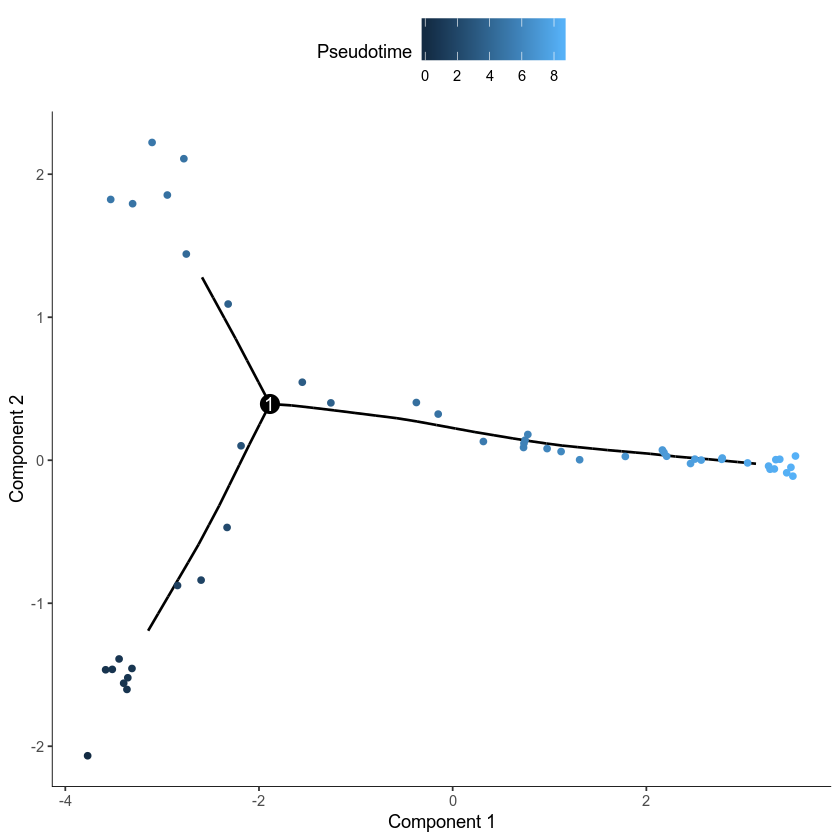

In [5]:
plot_cell_trajectory(HSMM_ord, color_by = "Pseudotime")

In [6]:
diff_test_res <- differentialGeneTest(HSMM_ord, cores=10, fullModelFormulaStr = "~sm.ns(Pseudotime)")
ordering_genes <- row.names (subset(diff_test_res, qval < 0.001))
HSMM_ord <- setOrderingFilter(HSMM_ord, ordering_genes)
HSMM_ord <- reduceDimension(HSMM_ord, max_components = 2,method = 'DDRTree')
HSMM_ord <- orderCells(HSMM_ord)

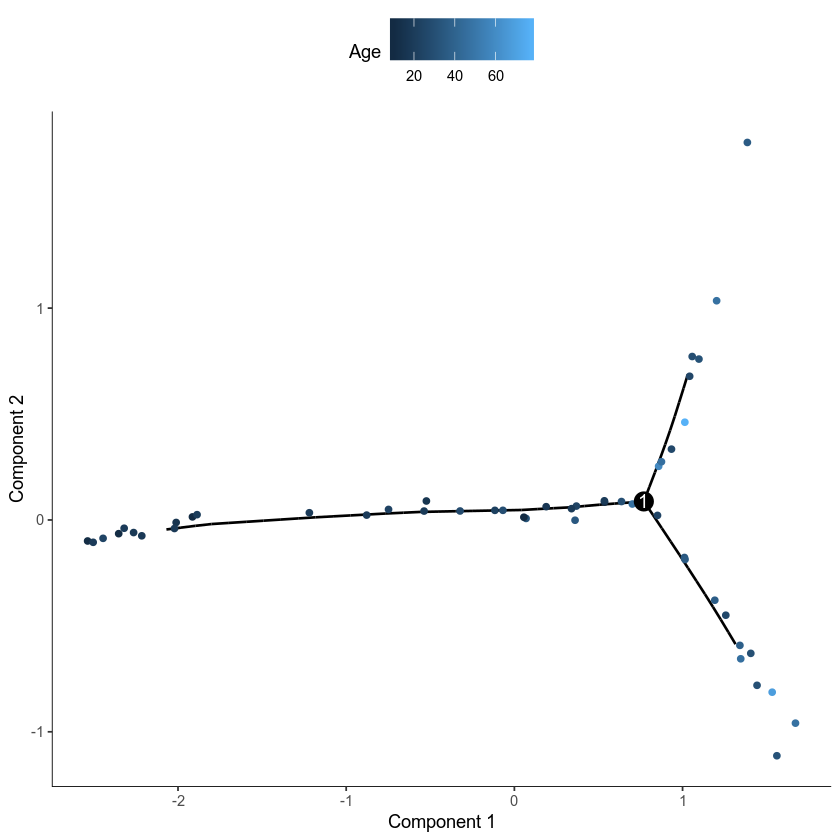

In [7]:
plot_cell_trajectory(HSMM_ord, color_by = "Age")

In [8]:
traj.plot <- plot_cell_trajectory(HSMM_ord, color_by = "Pseudotime")
point.data <- ggplot_build(traj.plot)[["plot"]][["data"]]

In [9]:
write.table(point.data, file='Datasets/Lab_Pvalb-vBC-Monocle.tsv', quote=FALSE, sep='\t', row.names=FALSE)

In [10]:
write(ordering_genes, file='References/GO/Genes_Monocle.txt', sep='\t')

In [11]:
length(ordering_genes)

[1] 74

In [12]:
head(diff_test_res)

,status,family,pval,qval,gene_short_name,num_cells_expressed,use_for_ordering
,<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<lgl>
0610009B22Rik,OK,negbinomial.size,0.8192791,1,0610009B22Rik,38,FALSE
0610010F05Rik,OK,negbinomial.size,0.3154653,1,0610010F05Rik,40,FALSE
0610010K14Rik,OK,negbinomial.size,0.5164320,1,0610010K14Rik,39,FALSE
0610030E20Rik,OK,negbinomial.size,0.9845824,1,0610030E20Rik,16,FALSE
0610040J01Rik,OK,negbinomial.size,0.3722487,1,0610040J01Rik,14,FALSE
1110004F10Rik,OK,negbinomial.size,0.9014843,1,1110004F10Rik,41,FALSE
